# A simple Lattice Bolzmann scheme in 2D square region

LBM direction (ref: http://sites.psu.edu/sihongyan/pflbm/):

    6 2 5
    3 0 1
    7 4 8

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from numba import jit

## Initialization

In [2]:
# == constants ==
nx = 200  # points in x direction
ny = 60  # points in y direction
nq = 9  # D2Q9 LBM
omega = 1 # relaxation parameters, between [0, 2]
force = 1e-4  # external forcing in x direction

cs2 = 1/3  # sound speed squared
cs = np.sqrt(cs2)  # sound speed
cs4 = cs2**2

# BC
wx = 30
lx = 50
wyh = int(ny - (ny - wx)/2);
wyl = int((ny - wx)/2);
b_left = int((nx - lx)/2); # 74
b_right = int((nx - lx)/2 + lx); #124

#  weights for D2Q9
w = np.array([4/9,
     1/9 ,1/9, 1/9, 1/9,
     1/36, 1/36, 1/36, 1/36])

# == prognostic variables ==
# Is (ny, nx, nq) a more efficient memory layout than (nq, ny, nx) ?
# +2 is for buffering regions
f = np.zeros((ny+2, nx+2, nq))  # particle population. 
feq = np.zeros((ny+2, nx+2, nq))  # The equilibrium distribution

ux = np.zeros((ny+2, nx+2))  #  macroscopic velocity in x
uy = np.zeros((ny+2, nx+2))  #  macroscopic velocity in y
rho = np.zeros((ny+2, nx+2))  # macroscopic density (sum of particle in all directions)

## The LBM solver code
Functions are written in C-like form. Only manipulating pointers. Do not return. Use loop insteads of vectorization.

In [3]:
@jit
def apply_forcing(f, force):
    for j in range(1, ny+1):
        for i in range(1, nx+1):
            if j >= wyh or j <= wyl:
                if i <= b_right and i >= b_left:
                    continue
            f[j, i, 1] += force
            f[j, i, 5] += force
            f[j, i, 8] += force

            f[j, i, 3] -= force
            f[j, i, 6] -= force
            f[j, i, 7] -= force

In [4]:
@jit
def equilibrium(rho, ux, uy, feq):   
    for j in range(1, ny+1):
        for i in range(1, nx+1):
            if j >= wyh or j <= wyl:
                if i <= b_right and i >= b_left:
                    feq[j,i,1] = 0.0
                    feq[j,i,2] = 0.0
                    feq[j,i,3] = 0.0
                    feq[j,i,4] = 0.0
                    continue
            # == expressions that can be reused ==  
            # Comments are the corresponding variable names in Sauro Succi's Fortran code
            ux_d_cs2 = ux[j, i] / cs2  # ui
            uy_d_cs2 = uy[j, i] / cs2  # vi
            ux2_d_2cs4 = ux[j, i]**2 / (2*cs4)  # u2
            uy2_d_2cs4 = uy[j, i]**2 / (2*cs4)  # v2
            
            v2_d_2cs2 = (ux[j, i]**2 + uy[j, i]**2) / (2*cs2)  # sumsq (v = velocity magnitude)
            v2_d_sp = v2_d_2cs2 * (1.0 - cs2) / cs2  # sumsq2  (sp = special)
            uxuy_d_cs4 = ux_d_cs2 * uy_d_cs2  # uv
        
            # == computing equilibrium ==
            feq[j, i, 0] = rho[j, i]*w[0]*(1 - v2_d_2cs2)

            feq[j, i, 1] = rho[j, i]*w[1]*(1 - v2_d_2cs2 + ux_d_cs2 + ux2_d_2cs4)
            feq[j, i, 2] = rho[j, i]*w[2]*(1 - v2_d_2cs2 + uy_d_cs2 + uy2_d_2cs4)
            feq[j, i, 3] = rho[j, i]*w[3]*(1 - v2_d_2cs2 - ux_d_cs2 + ux2_d_2cs4)
            feq[j, i, 4] = rho[j, i]*w[4]*(1 - v2_d_2cs2 - uy_d_cs2 + uy2_d_2cs4)

            feq[j, i, 5] = rho[j, i]*w[5]*(1 + v2_d_sp + ux_d_cs2 + uy_d_cs2 + uxuy_d_cs4)
            feq[j, i, 6] = rho[j, i]*w[6]*(1 + v2_d_sp - ux_d_cs2 + uy_d_cs2 - uxuy_d_cs4)
            feq[j, i, 7] = rho[j, i]*w[7]*(1 + v2_d_sp - ux_d_cs2 - uy_d_cs2 + uxuy_d_cs4)
            feq[j, i, 8] = rho[j, i]*w[8]*(1 + v2_d_sp + ux_d_cs2 - uy_d_cs2 - uxuy_d_cs4)

In [5]:
@jit
def collision(f, feq):
    for j in range(1, ny+1):
        for i in range(1, nx+1):
            if j >= wyh or j <= wyl:
                if i <= b_right and i >= b_left:
                    continue
            for q in range(nq):
                f[j, i, q] = (1.0 - omega)*f[j, i, q] + omega*feq[j, i, q]

In [6]:
@jit
def streaming(f):
    f_temp = f.copy()  # copy can be avoided with write-back strategy    
    for j in range(1, ny+1):
        for i in range(1, nx+1):
            # first-order neighbours
            f[j, i, 1] = f_temp[j, i-1, 1]
            f[j, i, 2] = f_temp[j-1, i, 2]
            f[j, i, 3] = f_temp[j, i+1, 3]
            f[j, i, 4] = f_temp[j+1, i, 4]
            
            # second-order neighbours
            f[j, i, 5] = f_temp[j-1, i-1, 5]
            f[j, i, 6] = f_temp[j-1, i+1, 6]
            f[j, i, 7] = f_temp[j+1, i+1, 7]
            f[j, i, 8] = f_temp[j+1, i-1, 8]

In [7]:
@jit
def macroscopic(f, rho, ux, uy):
    
    for j in range(1, ny+1):
        for i in range(1, nx+1):
            if j >= wyh or j <= wyl:
                if i <= b_right and i >= b_left:
                    rho[j, i] = 4.0
                    ux[j, i] = 0.0
                    uy[j, i] = 0.0
                    continue
            rho[j, i] = f[j, i, :].sum()
            
                # unroll loop explictly to avoid summing over zeros
            ux[j, i] = (f[j, i, 1] + f[j, i, 5] + f[j, i, 8] 
                           - f[j, i, 3] - f[j, i, 6] - f[j, i, 7]
                          )/rho[j, i]

            uy[j, i] = (f[j, i, 2] + f[j, i, 5] + f[j, i, 6] 
                           - f[j, i, 4] - f[j, i, 7] - f[j, i, 8]
                          )/rho[j, i]
            

In [8]:
@jit
def BC0(f):
    # north wall, bounce-back
    for i in range(1, nx+1):
        f[ny+1, i, 4] = f[ny, i, 2]
        f[ny+1, i, 8] = f[ny, i+1, 6]
        f[ny+1, i, 7] = f[ny, i-1, 5]
        
    # south wall, bounce-back
    for i in range(1, nx+1):
        f[0, i, 2] = f[1, i, 4]
        f[0, i, 6] = f[1, i-1, 8]
        f[0, i, 5] = f[1, i+1, 7]
    
    # west interface, periodic
    for j in range(1, ny+1):
        f[j, 0, 1] = f[j, nx, 1]
        f[j, 0, 5] = f[j, nx, 5]
        f[j, 0, 8] = f[j, nx, 8]
    
    # east interface, periodic
    for j in range(1, ny+1):
        f[j, nx+1, 3] = f[j, 1, 3]
        f[j, nx+1, 6] = f[j, 1, 6]
        f[j, nx+1, 7] = f[j, 1, 7] 
    
    
    for j in range(b_left, b_right+1):
        # top
        f[wyh, j, 4] = f[wyh+1, j, 2]
        f[wyh, j, 8] = f[wyh+1, j-1, 6]
        f[wyh, j, 7] = f[wyh+1, j+1, 5]
        # bottom 
        f[wyl, j, 2] = f[wyl-1, j, 4]
        f[wyl, j, 5] = f[wyl-1, j-1, 7]
        f[wyl, j, 6] = f[wyl-1, j+1, 8]
        
    for i in range(1, wyl+1):
        # left
        f[i, b_left, 3] = f[i, b_left+1, 1]
        f[i, b_left, 7] = f[i+1, b_left+1, 5]
        f[i, b_left, 6] = f[i-1, b_left+1, 8]
        # right
        f[i, b_right, 1] = f[i, b_right-1, 3]
        f[i, b_right, 5] = f[i-1, b_right-1, 7]
        f[i, b_right, 8] = f[i+1, b_right-1, 6]
    
    for i in range(wyh, ny+1):
        # left
        f[i, b_left, 3] = f[i, b_left+1, 1]
        f[i, b_left, 7] = f[i+1, b_left+1, 5]
        f[i, b_left, 6] = f[i-1, b_left+1, 8]
        #right
        f[i, b_right, 1] = f[i, b_right-1, 3]
        f[i, b_right, 5] = f[i-1, b_right-1, 7]
        f[i, b_right, 8] = f[i+1, b_right-1, 6]
        
    # square corners
    # top square
    f[ny, b_left, 7] = f[ny+1, b_left+1, 5] # north-west
    f[ny, b_right, 8] = f[ny+1, b_right-1, 6] # north-east
    f[wyh, b_right, 8] = f[wyh+1, b_right-1, 6] # south-west
    f[wyh, b_left, 7] = f[wyh+1, b_left+1, 5] # south-east
    # bottom square
    f[wyl, b_left, 6] = f[wyl-1, b_left+1, 8]
    f[wyl, b_right, 5] = f[wyh-1, b_right-1, 7]   
    f[0, b_left, 6] = f[1, b_left+1, 8]
    f[0, b_right, 5] = f[1, b_right-1, 7]

    # 4 corners, bounce-back
    f[ny+1, 0, 8] = f[ny, 1, 6]  # north-west
    f[0, 0, 5] = f[1, 1, 7]  # south-west
    f[ny+1, nx+1, 7] = f[ny, nx, 5]  # north-east
    f[0, nx+1, 6] = f[1, nx, 8]  # south-east

In [9]:
@jit
def initialize(f, feq, rho, ux, uy):
    '''
    Output
    ------
    f: 3D numpy array, population
    feq: 3D numpy array, equilibrium population
    rho: 2D numpy array, density
    ux, uy: 2D numpy array, velocity
    '''
    
    # uniform density
    rho[:] = 1.0
    for j in range(1, ny+1):
        for i in range(1, nx+1):
            if j >= wyh or j <= wyl:
                if i <= b_right and i >= b_left:
                    rho[j,i] = 0.0
                    continue
    ux[:] = 0.0
    uy[:] = 0.0
    
    # use equilibrium as initial population
    equilibrium(rho, ux, uy, feq)
    f[:] = feq

@jit
def lbm_solver(f, rho, ux, uy, nt):
    
    initialize(f, feq, rho, ux, uy)
    
    for it in range(0, nt):
        BC0(f)
        streaming(f)
        macroscopic(f, rho, ux, uy)
        equilibrium(rho, ux, uy, feq)
        collision(f, feq)
        apply_forcing(f, force)

In [10]:
%time lbm_solver(f, rho, ux, uy, 1000)

CPU times: user 4.41 s, sys: 286 ms, total: 4.69 s
Wall time: 5.05 s


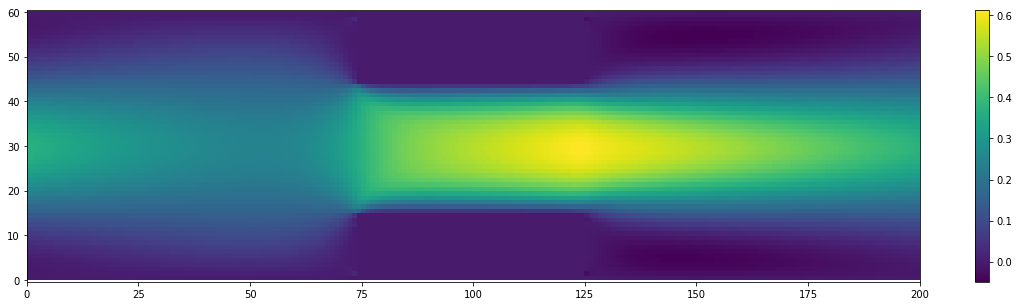

In [11]:
plt.figure(figsize=(20,5))
plt.pcolormesh(ux[1:-1,1:-1])#, vmin=0, vmax=0.3)
plt.axis('equal')
plt.colorbar()

In [30]:
ux[1:-1,2] - ux[1:-1,-2]

array([ 3.49943734e-04,  9.66031707e-04,  1.48714932e-03,  1.90987965e-03,
        2.23427166e-03,  2.46234247e-03,  2.59706291e-03,  2.64168416e-03,
        2.59939791e-03,  2.47322598e-03,  2.26608355e-03,  1.98099211e-03,
        1.62135882e-03,  1.19134630e-03,  6.96218507e-04,  1.42703167e-04,
       -4.60763122e-04, -1.10385750e-03, -1.77438718e-03, -2.45842967e-03,
       -3.14068672e-03, -3.80494953e-03, -4.43471693e-03, -5.01383602e-03,
       -5.52717528e-03, -5.96120238e-03, -6.30448431e-03, -6.54802520e-03,
       -6.68549683e-03, -6.71333129e-03, -6.63075315e-03, -6.43973961e-03,
       -6.14496099e-03, -5.75366941e-03, -5.27554036e-03, -4.72242420e-03,
       -4.10799258e-03, -3.44727782e-03, -2.75610381e-03, -2.05048329e-03,
       -1.34597960e-03, -6.57175558e-04,  2.80746241e-06,  6.22557665e-04,
        1.19254736e-03,  1.70502437e-03,  2.15388822e-03,  2.53431075e-03,
        2.84244421e-03,  3.07494510e-03,  3.22867753e-03,  3.30031460e-03,
        3.28616786e-03,  

In [19]:
ux[1:-1,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

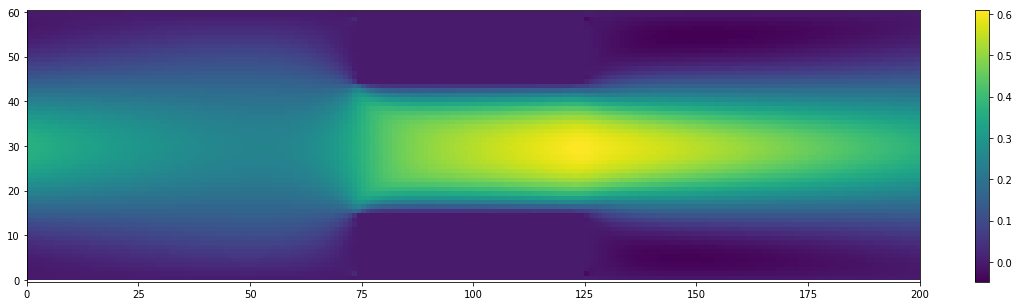

In [421]:
plt.figure(figsize=(20,5))
plt.pcolormesh(ux[1:-1,1:-1])#, vmin=0, vmax=0.3)
plt.axis('equal')
plt.colorbar()

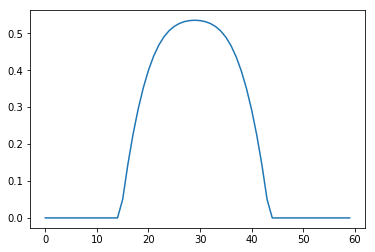

In [322]:
plt.plot(ux[1:-1, 100])  # cross-section

In [340]:
uy.max(), uy.min()  # should be almost zero

(0.14945349961468182, -0.15728429055624243)

In [341]:
rho.max(), rho.min()  # should be almost one

(1.2475660849518486, 0.0)